The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

# Import data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Training data

In [4]:
df = pd.read_csv('datasets/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


Data fields
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

# EDA

## Overview

In [7]:
# create a copy for EDA only
df_eda = df.copy()

In [8]:
df_eda.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## Create features

In [9]:
def distance(lat1, lat2, lon1, lon2):
    '''
    Simple distance calculator, assume angle is so small since we are only in new york city
    Returns distance in km
    '''
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = np.math.radians(lon1)
    lon2 = np.math.radians(lon2)
    lat1 = np.math.radians(lat1)
    lat2 = np.math.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.math.sin(dlat / 2)**2 + np.math.cos(lat1) * np.math.cos(lat2) * np.math.sin(dlon / 2)**2
 
    c = 2 * np.math.asin(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
    

In [10]:
df_eda['trip_distance_km'] = df_eda.apply(lambda x: distance(x['pickup_latitude'], x['dropoff_latitude'], x['pickup_longitude'], x['dropoff_longitude']),axis=1)	

In [11]:
df_eda['trip_distance_km_rounded'] = df_eda['trip_distance_km'].round(decimals=1)

In [12]:
feat_num_eda = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']
feat_cat_eda = ['vendor_id', 'store_and_fwd_flag']
feat_dt_eda = ['pickup_datetime', 'dropoff_datetime']

target_eda = ['trip_duration']

## Numerical features
- drop off and pick up locations
    - locations way out of the vicinity of New York City to be removed
- distribution of trip distance
    - exponentially distributed
    - zeros and outliers to be removed
- passenger count
    - 1m from 1.4m trips were single passenger trips

In [13]:
df_eda[feat_num_eda].describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,3.440864e+00
std,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,4.296538e+00
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,1.231837e+00
50%,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,2.093717e+00
75%,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,3.875337e+00
max,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.240909e+03


In [14]:
def filter_records_by_num_feat(df):
    '''
    Filter records by numerical features' constraints
    - keep only pickups and dropoffs within the vicinity of New York City
    - remove records from temp_df having trip_distance_km as zeros or outliers
    '''
    # temp temp_df 
    temp_df = df.copy()
    # get stats before any filtering
    trip_distance_mean, trip_distance_std = temp_df['trip_distance_km'].mean(), temp_df['trip_distance_km'].std()

    # filter by lat and lon 
    NYC_MIN_LON, NYC_MAX_LON = -74.4, -73.4 # approx from power bi viz
    NYC_MIN_LAT, NYC_MAX_LAT = 40, 41.6
    temp_df = temp_df[
        ((temp_df['pickup_longitude'] >= NYC_MIN_LON) & (temp_df['pickup_longitude'] <= NYC_MAX_LON)) & 
        ((temp_df['pickup_latitude'] >=  NYC_MIN_LAT) & (temp_df['pickup_latitude'] <=  NYC_MAX_LAT)) &
        ((temp_df['dropoff_longitude'] >= NYC_MIN_LON) & (temp_df['dropoff_longitude'] <= NYC_MAX_LON)) &
        ((temp_df['dropoff_latitude'] >=  NYC_MIN_LAT) & (temp_df['dropoff_latitude'] <=  NYC_MAX_LAT))
        ]
    # remove zeros and outliers for trip distance
    temp_df = temp_df[temp_df['trip_distance_km'] != 0]
    trip_distance_lower = trip_distance_mean - 3*trip_distance_std
    trip_distance_upper = trip_distance_mean + 3*trip_distance_std
    return temp_df[(temp_df['trip_distance_km'] < trip_distance_upper) & (temp_df['trip_distance_km'] > trip_distance_lower)]

In [15]:
df_eda_filtered = filter_records_by_num_feat(df_eda)
print(df_eda_filtered.info())
df_eda_filtered[feat_num_eda].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412604 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1412604 non-null  object        
 1   vendor_id                 1412604 non-null  int64         
 2   pickup_datetime           1412604 non-null  datetime64[ns]
 3   dropoff_datetime          1412604 non-null  datetime64[ns]
 4   passenger_count           1412604 non-null  int64         
 5   pickup_longitude          1412604 non-null  float64       
 6   pickup_latitude           1412604 non-null  float64       
 7   dropoff_longitude         1412604 non-null  float64       
 8   dropoff_latitude          1412604 non-null  float64       
 9   store_and_fwd_flag        1412604 non-null  object        
 10  trip_duration             1412604 non-null  int64         
 11  trip_distance_km          1412604 non-null  float6

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
count,1.412604e+06,1.412604e+06,1.412604e+06,1.412604e+06,1.412604e+06,1.412604e+06
mean,1.662426e+00,-7.397652e+01,4.075263e+01,-7.397485e+01,4.075275e+01,2.967110e+00
std,1.313574e+00,2.991740e-02,2.489055e-02,2.949210e-02,2.985556e-02,2.696506e+00
min,0.000000e+00,-7.439355e+01,4.022580e+01,-7.439851e+01,4.022580e+01,4.241750e-04
25%,1.000000e+00,-7.399206e+01,4.073840e+01,-7.399137e+01,4.073689e+01,1.220936e+00
50%,1.000000e+00,-7.398200e+01,4.075471e+01,-7.397993e+01,4.075488e+01,2.042420e+00
75%,2.000000e+00,-7.396827e+01,4.076865e+01,-7.396369e+01,4.077001e+01,3.644642e+00
max,8.000000e+00,-7.340162e+01,4.125688e+01,-7.340162e+01,4.125689e+01,1.633015e+01


<AxesSubplot:xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

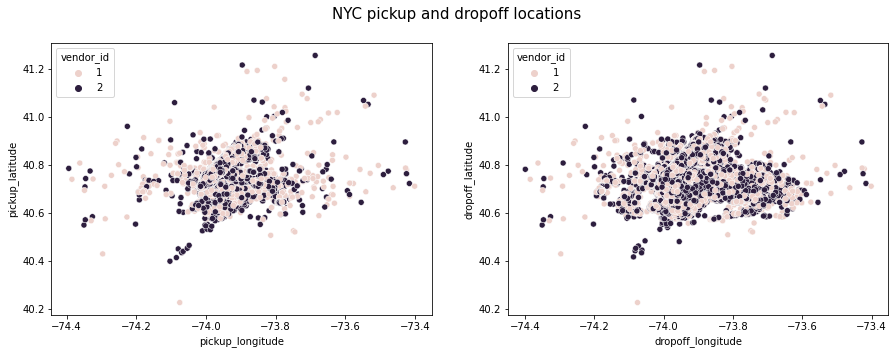

In [16]:
plt.figure(figsize=(15,5))
plt.suptitle('NYC pickup and dropoff locations', size=15)

plt.subplot(121)
sns.scatterplot(data=df_eda_filtered, y='pickup_latitude', x='pickup_longitude', hue='vendor_id')

plt.subplot(122)
sns.scatterplot(data=df_eda_filtered, y='dropoff_latitude', x='dropoff_longitude', hue='vendor_id')

<AxesSubplot:xlabel='trip_distance_km'>

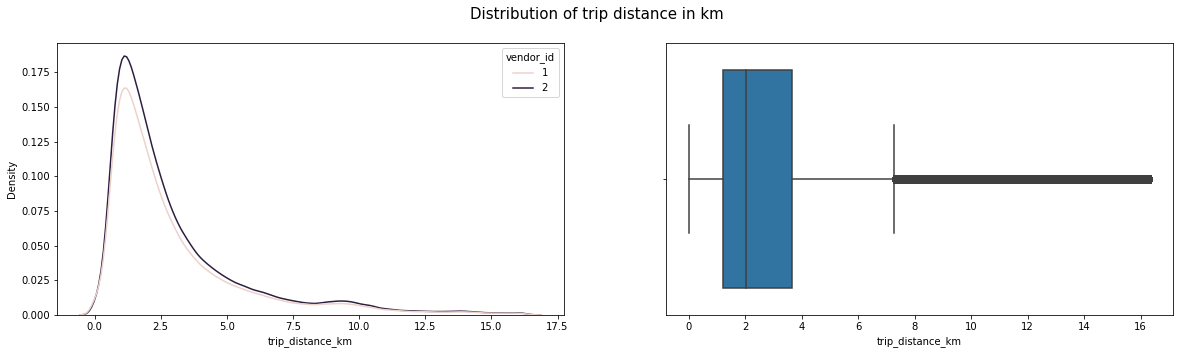

In [17]:
plt.figure(figsize=(20,5))
plt.suptitle('Distribution of trip distance in km', size=15)

plt.subplot(121)
sns.kdeplot(data=df_eda_filtered, x='trip_distance_km', hue='vendor_id')
plt.subplot(122)
sns.boxplot(data=df_eda_filtered, x='trip_distance_km')

Text(0.5, 1.0, 'Passengers per trip')

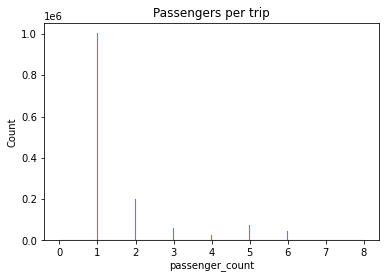

In [18]:
sns.histplot(data=df_eda_filtered, x='passenger_count')
plt.title('Passengers per trip')

## Categorical features
- 2 vendors have fair share of trips
- store_and_fwd_flag overwhelmlingly = N (can be removed from model)

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='count'>

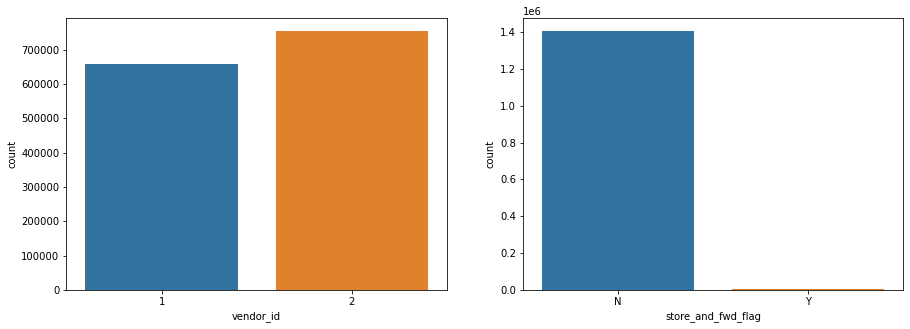

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.countplot(data=df_eda_filtered, x='vendor_id')
plt.subplot(122)
sns.countplot(data=df_eda_filtered, x='store_and_fwd_flag')

## Datetime features
- combine with other features to look for info

In [20]:
print(df_eda_filtered['pickup_datetime'].min(), '-', df_eda_filtered['pickup_datetime'].max())
print(df_eda_filtered['dropoff_datetime'].min(), '-', df_eda_filtered['dropoff_datetime'].max())

2016-01-01 00:00:17 - 2016-06-30 23:59:39
2016-01-01 00:03:31 - 2016-07-01 23:02:03


Text(0, 0.5, 'Trip counts')

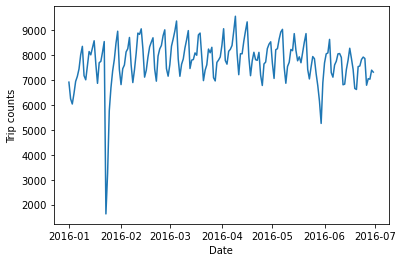

In [21]:
df_eda_filtered.groupby(df_eda_filtered['pickup_datetime'].dt.date)['id'].count().plot()
plt.xlabel('Date')
plt.ylabel('Trip counts')

Text(0, 0.5, 'Trip counts')

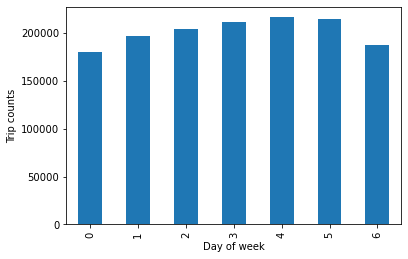

In [22]:
df_eda_filtered.groupby(df_eda_filtered['pickup_datetime'].dt.day_of_week)['id'].count().plot(kind='bar')
plt.xlabel('Day of week')
plt.ylabel('Trip counts')

## Target variable
- duration on it's own
    - outliers to be removed (duration of 2.2million secounds LOL)
- duration vs distance rounded
    - linear relationship
    - low duration deviation at each distance
- duration by time and vendor
    - duration of vendor 2 is considerably higher --> turns out this is from the outlier
    - after removing outliers duration of both vendors are similar

<AxesSubplot:xlabel='trip_duration'>

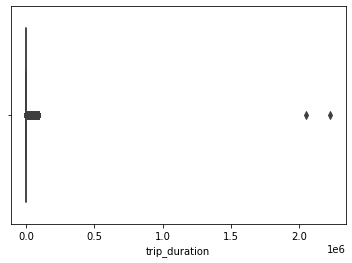

In [23]:
sns.boxplot(data=df_eda_filtered, x='trip_duration')

In [24]:
def filter_records_by_target(df):
    '''
    Filter records by target variable constraints
    - remove records having trip_duration as zeros or outliers
    '''
    # temp temp_df 
    temp_df = df.copy()
    # get stats
    target_mean, target_std = temp_df['trip_duration'].mean(), temp_df['trip_duration'].std()

    # remove zeros and outliers for duration
    temp_df = temp_df[temp_df['trip_duration'] != 0]
    target_lower = target_mean - 3*target_std
    target_upper = target_mean + 3*target_std
    return temp_df[(temp_df['trip_duration'] < target_upper) & (temp_df['trip_duration'] > target_lower)]

In [25]:
df_eda_filtered_2 = filter_records_by_target(df_eda_filtered)
print(df_eda_filtered_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410636 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1410636 non-null  object        
 1   vendor_id                 1410636 non-null  int64         
 2   pickup_datetime           1410636 non-null  datetime64[ns]
 3   dropoff_datetime          1410636 non-null  datetime64[ns]
 4   passenger_count           1410636 non-null  int64         
 5   pickup_longitude          1410636 non-null  float64       
 6   pickup_latitude           1410636 non-null  float64       
 7   dropoff_longitude         1410636 non-null  float64       
 8   dropoff_latitude          1410636 non-null  float64       
 9   store_and_fwd_flag        1410636 non-null  object        
 10  trip_duration             1410636 non-null  int64         
 11  trip_distance_km          1410636 non-null  float6

<AxesSubplot:xlabel='trip_duration'>

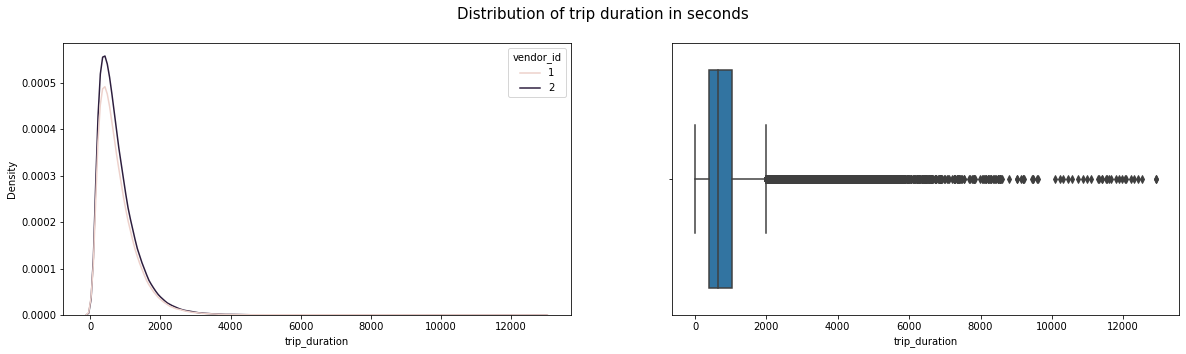

In [26]:
plt.figure(figsize=(20,5))
plt.suptitle('Distribution of trip duration in seconds', size=15)

plt.subplot(121)
sns.kdeplot(data=df_eda_filtered_2, x='trip_duration', hue='vendor_id')
plt.subplot(122)
sns.boxplot(data=df_eda_filtered_2, x='trip_duration')

<AxesSubplot:xlabel='trip_distance_km_rounded', ylabel='trip_duration'>

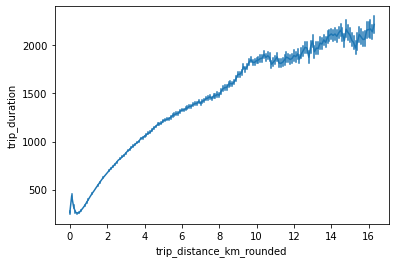

In [27]:
sns.lineplot(
    data=df_eda_filtered_2, x='trip_distance_km_rounded', y='trip_duration',
    markers=True, err_style="bars", ci=95
    )

Text(0, 0.5, 'Average duration')

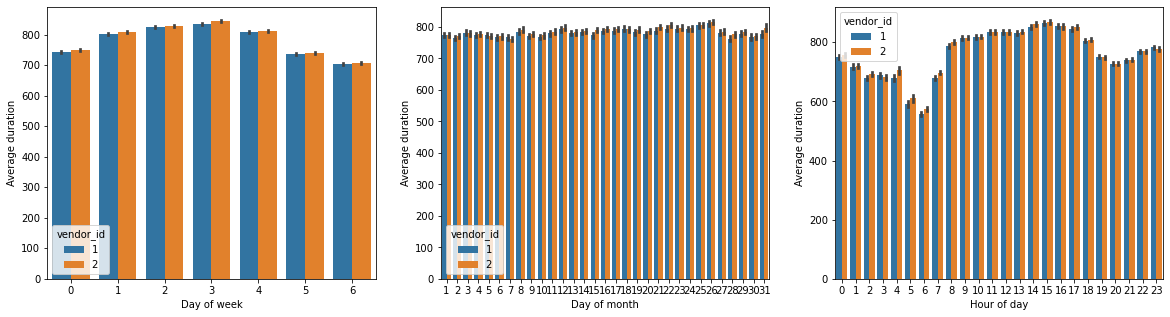

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(131)
sns.barplot(data=df_eda_filtered_2, x= df_eda_filtered_2['pickup_datetime'].dt.day_of_week, y='trip_duration', hue='vendor_id')
plt.xlabel('Day of week')
plt.ylabel('Average duration')

plt.subplot(132)
sns.barplot(data=df_eda_filtered_2, x= df_eda_filtered_2['pickup_datetime'].dt.day, y='trip_duration', hue='vendor_id')
plt.xlabel('Day of month')
plt.ylabel('Average duration')

plt.subplot(133)
sns.barplot(data=df_eda_filtered_2, x= df_eda_filtered_2['pickup_datetime'].dt.hour, y='trip_duration', hue='vendor_id')
plt.xlabel('Hour of day')
plt.ylabel('Average duration')

# Preprocess data for model
- from raw training dataset --> ready for model
    - feature engineering
    - filter out records that have zeros or outliers numerical features (do this before going into the pipeline)
    - numerical pipeline: scale
    - categorical pipeline: 
- raw training set
    - feature engineering
    - numerical pipeline: scale

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


## Feature engineering

In [30]:
def feature_engineering(df):
    '''
    creates extra features for model training
    '''
    # creates a copy to prevent mutating the input df
    df = df.copy()
    # trip duration
    df['trip_distance_km'] = df.apply(
        lambda x: distance(x['pickup_latitude'], x['dropoff_latitude'], x['pickup_longitude'], x['dropoff_longitude']),
        axis=1
        )
    # datetime hour of day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    # datetime day of week
    df['pickup_dow'] = df['pickup_datetime'].dt.day_of_week
    
    return df

df_fe = feature_engineering(df)

In [31]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  trip_distance_km    1458644 non-null  float64       
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_dow  

## Filtering

In [32]:
df_fe_filtered = filter_records_by_target(filter_records_by_num_feat(df_fe))

In [33]:
df_fe_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410636 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1410636 non-null  object        
 1   vendor_id           1410636 non-null  int64         
 2   pickup_datetime     1410636 non-null  datetime64[ns]
 3   dropoff_datetime    1410636 non-null  datetime64[ns]
 4   passenger_count     1410636 non-null  int64         
 5   pickup_longitude    1410636 non-null  float64       
 6   pickup_latitude     1410636 non-null  float64       
 7   dropoff_longitude   1410636 non-null  float64       
 8   dropoff_latitude    1410636 non-null  float64       
 9   store_and_fwd_flag  1410636 non-null  object        
 10  trip_duration       1410636 non-null  int64         
 11  trip_distance_km    1410636 non-null  float64       
 12  pickup_hour         1410636 non-null  int64         
 13  pickup_dow  

## Preprocess for model
- transform only no removal (will cause index problem when joining)

In [89]:
X_cols_num = [
    'passenger_count',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'trip_distance_km',
    'pickup_hour', 'pickup_dow'
]
X_cols_cat = [
    # 'vendor_id',
    # 'store_and_fwd_flag'
]
X_cols = X_cols_num + X_cols_cat
y_cols = ['trip_duration']


look at correlation of num features for feature selection
- all are not correlated enough to eliminate a feature

<AxesSubplot:>

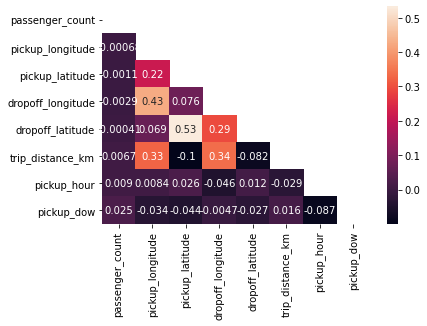

In [100]:
# look at correlation of the features
corr_matrix = df_fe_filtered[X_cols_num].corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, annot=True, mask=mask)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline(
    steps=[
        # ('selector', FunctionTransformer(lambda df: df[X_cols_num])),
        ('standard_scaler', StandardScaler()),
    ])
# cat_pipeline = Pipeline(
#     steps=[
#     ])

preprocessing_pl = ColumnTransformer([
    ('num', num_pipeline, X_cols_num),
    # ('cat', cat_pipeline, X_cols_cat),
    ])

In [91]:
X = preprocessing_pl.fit_transform(df_fe_filtered[X_cols])
y = df_fe_filtered[y_cols]

print(X.shape, y.shape)

(1410636, 8) (1410636, 1)


In [92]:
from sklearn.model_selection import train_test_split

X_train, X_vld, y_train, y_vld = train_test_split(X, y, train_size=0.9, random_state=42)

# Explore models
- Ridge:
    - Trip distance --> rmse train 386, rmse vld 384
    - Trip distance, Pickup Dropoff lat lon --> rmse train 382, rmse vld 380    
    - All num --> rmse train 380, rmse vld 378
- Lasso:
    - All num --> rmse train 380, rmse vld 378
        - passenger_count 3.280214436250335
        - pickup_longitude -18.866200239605078
        - pickup_latitude 23.277154661185282
        - dropoff_longitude -28.94133580123565
        - dropoff_latitude -39.55765227523309
        - **trip_distance_km** 418.5356137166489
        - pickup_hour 24.130504004957892
        - pickup_dow -24.234781098325627
- BaggingRegressor:
    - All num --> rmse 128, rmse vld 299
    - overfit
- RandomForestRegressor:
    - All num --> rmse train 108, rmse vld 285
    - overfit
    - took 22 min!
- GradinetBoostingRegressor:
    - All num --> rmse train 324, 322

In [105]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def evaluate_regressor(regressor, X_train, y_train, X_vld, y_vld):
    regressor.fit(X_train, y_train)
    # make predictions on training data
    y_pred_train = regressor.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    # rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    # make predictions on test data
    y_pred_vld = regressor.predict(X_vld)
    rmse_vld = np.sqrt(mean_squared_error(y_vld, y_pred_vld))
    # rmsle_vld = np.sqrt(mean_squared_log_error(y_vld, y_pred_vld))

    print(f'Predicting with {regressor}')
    print('Training error:')
    print(f'Root mean squared error = {rmse_train} sec')
    # print(f'Root mean squared log error = {rmsle_train}')
    print('Validation error:')
    print(f'Root mean squared error = {rmse_vld} sec')
    # print(f'Root mean squared log error = {rmsle_vld}')

    return regressor, y_pred_train, y_pred_vld
    # return y_pred_train

In [110]:
from sklearn.linear_model import Ridge
ridge_reg, y_pred_train, y_pred_vld = evaluate_regressor(Ridge(), X_train, y_train, X_vld, y_vld)

Predicting with Ridge()
Training error:
Root mean squared error = 380.7169918068224 sec
Validation error:
Root mean squared error = 378.5507042795594 sec


In [112]:
from sklearn.linear_model import Lasso
lasso_reg, y_pred_train, y_pred_vld = evaluate_regressor(Lasso(), X_train, y_train, X_vld, y_vld)

for f,c in zip(X_cols, lasso_reg.coef_):
    print(f, c)


Predicting with Lasso()
Training error:
Root mean squared error = 380.7324716573512 sec
Validation error:
Root mean squared error = 378.5536618882573 sec
passenger_count 3.280214436250335
pickup_longitude -18.866200239605078
pickup_latitude 23.277154661185282
dropoff_longitude -28.94133580123565
dropoff_latitude -39.55765227523309
trip_distance_km 418.5356137166489
pickup_hour 24.130504004957892
pickup_dow -24.234781098325627


In [113]:
from sklearn.ensemble import BaggingRegressor
br = evaluate_regressor(
    BaggingRegressor(),
    X_train, y_train.to_numpy().ravel(),
    X_vld, y_vld.to_numpy().ravel())

Predicting with BaggingRegressor()
Training error:
Root mean squared error = 128.26483354753526 sec
Validation error:
Root mean squared error = 299.5217748624082 sec


In [114]:
from sklearn.ensemble import RandomForestRegressor
rf = evaluate_regressor(
    RandomForestRegressor(),
    X_train, y_train.to_numpy().ravel(),
    X_vld, y_vld.to_numpy().ravel())

Predicting with RandomForestRegressor()
Training error:
Root mean squared error = 108.09283903273239 sec
Validation error:
Root mean squared error = 285.6653782061089 sec


In [116]:
from sklearn.ensemble import GradientBoostingRegressor
gb = evaluate_regressor(
    GradientBoostingRegressor(n_estimators=100),
    X_train, y_train.to_numpy().ravel(),
    X_vld, y_vld.to_numpy().ravel())

Predicting with GradientBoostingRegressor()
Training error:
Root mean squared error = 324.9942324697641 sec
Validation error:
Root mean squared error = 322.75314291541196 sec


# Tune hyperparams

In [119]:
br[0].get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [127]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [5,10,20]}
grid_search = GridSearchCV(BaggingRegressor(), param_grid, cv=2)
grid_search.fit(X, y.to_numpy().ravel())

GridSearchCV(cv=2, estimator=BaggingRegressor(),
             param_grid={'n_estimators': [5, 10, 20]})

In [128]:
grid_search.best_params_

{'n_estimators': 20}

In [129]:
grid_search.best_score_

0.7151402347017192

# Make predictions on unseen data

In [41]:
df_test = pd.read_csv('datasets/test.csv', parse_dates=['pickup_datetime'])

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [43]:
df_test_fe = feature_engineering(df_test)
X_test = preprocessing_pl.transform(df_test_fe[X_cols])